## Subsurface Machine Learning

Xiao Luo

# Executive Summary

In a multidimensional data, the curse of the dimensionality often causes the model to overfit the data. In principle, dimensionality reduction on the sample data helps avoid overfitting and improve the accuracy of the model. The goal of this workflow is to combine principal component analysis (PCA) and random forest regression to build a model to estimate the production data. The hyperparameters of the model are the maximum tree depth, number of trees, and number of principle componnets (PCs) to be inputted when training the model. 

In this workflow, the sample data are first transformed into principal components space. The aim is to use the principal component(s) to predict standardized production. To tune the random forest regressor, all principle components are inputted into the model and cross validate the maximum tree depth and the number of trees. With tuned maximum tree depth and the number of trees, the model is further tuned by change the number of principle components as a model hyperparameter. To ensure the number of PCs does not impact the random forest hyperparameters, I re-validate (re-tuned) the maximum tree depth and number of trees. Lastly, I finalized the model and compared the model prediction versus actual production.

Without principal component analysis, the model with only 2 predictors (porosity and brittleness) performs better than the model with all 6 predictors. This shows that a higher dimensional data does not necessary lead to better prediction. By combining principal components analysis and random forest regressor, the model estimation on the production can be significantly improved without explicit feature selections. 

Although random forest regressor has feature importance functionality, using the top two feature results in a much worse fit compared to porosity and brittleness. Thus, the feature importance function is not reliable for this dataset. In contrary, PCA is more robust. All of the original data can be decomposed into PCs, and non-important PCs can be easily discarded. Principal components analysis is not the only method for dimensionality reduction, and other techniques, such as pairwise distances, should also be explored.


# Introduction

The hypothesis is that using more predictors features leads to overfit and a worst estimation, and dimensionality reduction using principal component analysis. To test this hypothesis, I will first use the sample data (synthetic data) to model production rate. The R2 value will be used to quantify the goodness of the model.

The machine/regressor used in this study is random forest regressor. Random forest regressor is an extension to the ensemble tree method. It uses bootstraped samples for tree-bagging, and it randomly select a feature from a features subset for each split. The random forest forces each tree to be decorrelated, hence, significantly reduces the variance in the estimate. The hyperparameters for the random forest regressor are the maximum tree depth and number of trees (bagging), when the method is combined with principal component analysis (with all features of the sample data), the number of PCs can also be a hyperparameter.

Principal component analysis is a method that decompose the original feature into principal components. The principal component are ranked with the ratio variance explained. A higher variance explained means the principle component is more important. Hence, principal component analysis is analogous to the feature ranking methods, the difference is that principle components generally do not have explicit physical meaning. Still, they are correlated with original features, and can be used as predictors. The main limitation of this method is that it relies on linear assumptions. For highly non-linear correlation between predictors and response, the principal components may not be representative. In this case, it is recommended to linearize the data through a rank transform or other feature engineering methods.

K-fold cross validation is used to tune the aformentioned hyperparameter. This method divide the training data into K bins (in this case K=5). It retains the data for $i$ bin, and build the model from all other bin ($n\neq i$), it calculate the R2 score between the model estimate and data for $i$ bin, and calculation step continues until $i=K$. The average R2 for all K bins quantify the goodness-of-fit and the hyperparameters.


# Workflow outline

This workflow can be summarized into the following sections:

#### Section 0. workflow setup
Load self-defined functions, change working directory, and load sample data

#### Section 1. data preparation
1. Check general statistics of the sample data and truncate unphysical data. Also making cross plot of the sample to make ocular inspections
2. Perform principal component analysis of the data. Save the principal component score for later use

#### Section 2. compare random forest model with 2 predictors to 6 predictors
1. split the sample data into training and testing data
2. fit a random forest model with only porosity and brittleness in training data, and obtain the R2 score on the testing data
3. fit a random forest model with all all (six) features, and obtain the R2 score

#### Section 3. combine principal components with random forest
1. load the principal component scores (obtained in section 1), and standardize the production data. The predictors are the principle components, and response is the standardized production. 
2. apply K-fold cross validation to tune the maximum tree depth and number of trees (use six PCs as input data)
3. use previous tuned maximum tree depth and number of trees, use K-fold method to tune the number of PCs
4. once the number of PCs is tuned, go back to step 2 to verify that the maximum tree depth and number of tree are still valid

#### Section 4. finalize the model and compare model estimate to data
1. Re-split the training and testing data
2. fit the random forest model with the training data and the tuned hyperparameters
3. make prediction using the testing data
4. re-scale the prediction to the original space, and plot the model prediction as a function of actual production


### Section 0. workflow setup
load two user defined functions here:

1st function takes the input and perform principal analysis

2nd function is a visualization of the random forest tree model (only limited to 2 predictors)

In [1]:
# section 1 loading self-defined functions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# custom made function are defined here:
# 1.PCA analysis
def principal_component_analysis(df, p):
    # this function perform principal component analysis on the input data frame
    # df is the input dataframe 
    # p is the number of priciple components
    #1. standardized the input data
    scaler = StandardScaler().fit(df)  # scaler object for the original data
    df_st = scaler.transform(df)   # transform the data
     
    n_features = len(df_st[0]) # n_feature is simply number of columns from input
    #print(n_features)
     # set hyper parameters of principal component
    pca = PCA(n_components=n_features).fit(df_st) # extensiate the object    

    # calculate priciple component scores
    pc_score = pca.transform(df_st) # calculate principal components scores with the created method
    
    # generate name for the component score: PC#1, PC#2.....PC#n
    pc_feature = ['PC#' + x for x in (np.arange(n_features)+1).astype(str)]
    df_pc_score = pd.DataFrame(data=pc_score, columns=pc_feature)  # convert PC score array to data frame
    
    # reconstruct data by reverse transform the component score and loading
    data_it = scaler.inverse_transform(pca.transform(df_st)[:,:p] @ pca.components_[:p,:])
    df_rc = pd.DataFrame(data=data_it, columns=df.columns)  # dimensionality reduced dataframe
    
    # the function returns the following dictionary
    return {'df_rc': df_rc, # data with reduced dimensionality in the original space 
            'df_pcs': df_pc_score, # data with reduced dimensionality in the principal component space 
            'pca_result': pca , # the pca instance used (this contains the explained variance)
            'scaler': scaler}   # the standard scaler used 

#2. this function takes data and split the data in to train and test
#   it then build a random forest and return the R2 of the fit
def build_random_forest(predictors,response,split_params,model_params):
    # predictors and response are self-explainartory
    # params is the object contains model hyperparameter, 
    # for random_forest, params contains: 
    
    #1. train test split
    tsize=split_params.test_size
    rand_seed=split_params.rand_seed
    X_train, X_test, i_train, i_test = train_test_split(predictors, np.arange(len(predictors)),
                                                    test_size=tsize, random_state=rand_seed)
    y_train = response[i_train] # get training response
    y_test = response[i_test] # get testing response
    
    # import hyperparameters
    max_depth = model_params.max_depth; min_samples_leaf = model_params.min_samples_leaf
    num_tree = model_params.num_tree;
    
    forest_model = RandomForestRegressor(max_depth=max_depth, random_state=rand_seed,
                                        n_estimators=num_tree, max_features='sqrt',oob_score=True) # max feature is sqrt

    RFRegr = forest_model.fit(X_train, y_train)
    # R2 for out of bag sample
    R2_oob = RFRegr.oob_score_    
    # R2 for testing data
    R2_test=RFRegr.score(X_test,y_test)
    
    output = lambda: None #initialize an empty object
    
    # output the model and fitting scores
    output.regressor = RFRegr
    output.R2_oob = R2_oob
    output.R2_test = R2_test
    output.i_test = i_test
    output.i_train = i_train
      
    fit_str_oob = str(np.min(predictors.shape))+' predictors: the R^2 of the out-of-bag score is '+str(R2_oob)
    print(fit_str_oob)
  
    fit_str_test =str(np.min(predictors.shape))+' predictors: the R^2 of the testing data is '+str(R2_test)
    print(fit_str_test)    
    return output


#3. this function create meshgrid of the predictors space, makeing model estiamte on the mesh and 
#   contour plot the model prediction across the mesh
def visualize_model(model,data,fig_input):
    # specify the x and y meshgrid
    #xcol = fig_input.xcol; ycol = fig_input.ycol
    x = data[:,0]; y = data[:,1]; z_scatter= data[:,2]; #get the x y and z testing data
    
    #generate mesh grid
    xx, yy = np.meshgrid(np.linspace(fig_input.xmin, fig_input.xmax, fig_input.npx), 
                         np.linspace(fig_input.ymin, fig_input.ymax, fig_input.npy))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    z_min = fig_input.zmin
    z_max = fig_input.zmax
    
    lv=np.linspace(z_min, z_max, 100)

    csf = plt.contourf(xx, yy, Z, cmap=fig_input.cmap, vmin=z_min, vmax=z_max, levels=lv)

    im = plt.scatter(x,y,s=None, c=z_scatter, marker=None, cmap=fig_input.cmap, norm=None, 
                 vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")

    plt.title(fig_input.title)
    plt.xlabel(fig_input.xlabel)
    plt.ylabel(fig_input.ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(fig_input.cbartitle, rotation=270, labelpad=20)
    return Z   

specify working directory:

In [2]:
# Section 1 set working directory
import os    # set working directory, run executables
path=os.path.expanduser("~\\Box Sync\\2019\\PGE 383 Subsurface Maching Learning\\Project")  
# get the relative path to the user directory
os.chdir(path) # set the working directory   

load the sample data, making deep copy as backup file

In [3]:
# section 1, load basic python packages, and load the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

df = pd.read_csv('unconv_MV_v5.csv')           # load our data table 
# note that this data set are synthetic, 
# by courtesy of Dr. Mike Pyrcz:  
df_backup = copy.deepcopy(df)                  # make a backup copy of the input data
df = df.drop(columns = ['Well'])               # drop the well number,
df.describe().transpose()      

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.990450,0.481588,-0.190000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,4311.219852,992.038414,2107.139414,3618.064513,4284.687348,5086.089761,6662.622385


there are negative values in the TOC, these values are unphysical, hence I truncate the negative values to 0. 

In [4]:
# Part I, continue, truncate unphysical (negative) data
# TOC is negative, I truncate it to zero
df[df<0] = 0
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
Por,200.0,14.991150,2.971176,6.550000,12.912500,15.070000,17.402500,23.550000
Perm,200.0,4.330750,1.731014,1.130000,3.122500,4.035000,5.287500,9.870000
AI,200.0,2.968850,0.566885,1.280000,2.547500,2.955000,3.345000,4.630000
Brittle,200.0,48.161950,14.129455,10.940000,37.755000,49.510000,58.262500,84.330000
TOC,200.0,0.991950,0.478264,0.000000,0.617500,1.030000,1.350000,2.180000
VR,200.0,1.964300,0.300827,0.930000,1.770000,1.960000,2.142500,2.870000
Prod,200.0,4311.219852,992.038414,2107.139414,3618.064513,4284.687348,5086.089761,6662.622385


The data looks good now, and let us transform the data into principal component scores, and then, compare it with the original data.

### Section 1. data preparation

Tranform the sample data into principal component scores, plot the cumulative variance explained as a function of PCS

Variance explained by principal components:[0.488 0.24  0.136 0.099 0.027 0.007 0.003]


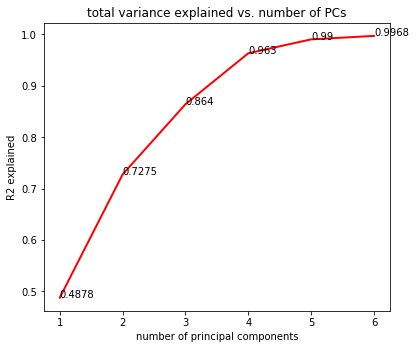

In [5]:
# Part I, transform the data into principal components
# with p pricniple components
p = 6 # using all 6 principal components
result = principal_component_analysis(df,p)
# the result returns a dictionary:
# {'df_rc': reconstructed data, 'df_pcs': PC scores,'pca_result': PCA fit ,'scaler': data scaler}

df_recon = result['df_rc'] # inverse transformed data
df_PCS = result['df_pcs']  # data in principal component space  
pca_model = result['pca_result']
var_explained_pc = pca_model.explained_variance_ratio_
var_explained_total = np.sum(var_explained_pc[:p])
print('Variance explained by principal components:' + str(np.round(var_explained_pc,3)))

total_var_explained=np.zeros(p)
for i in np.arange(p):
    var = np.sum(var_explained_pc[:i+1])
    total_var_explained[i]=var

plt.subplot(111)
plt.plot(np.arange(p)+1, total_var_explained, color = 'red', linewidth = 2)
for i in np.arange(p):
    txt = str(np.round(total_var_explained[i],4))
    plt.annotate(txt, (i+1, total_var_explained[i]))
    
plt.title('total variance explained vs. number of PCs'); 
plt.xlabel('number of principal components'); plt.ylabel('R2 explained')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=1.0, wspace=0.3, hspace=0.2)


More principle components retain the variance of the dataset, but it may also causes multicolinearity and overfit problems.

From the explained variance ratio, I would expect $R^2$ to be 0.728 for using 2 principal components, and 0.864 when using 3 principal components.

I use pairplots to visualize sample statistics. The first plots are the reconstructed data with principal component analysis, and the second plots are the original data. The comparison of the two plots shows that the principal component analysis reproduce the data adaquately, and I can proceed to the next step.

Text(0.5, 1, 'original data')

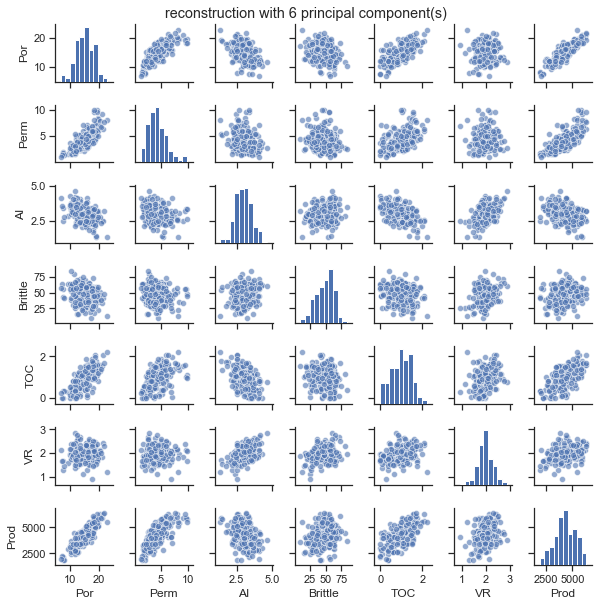

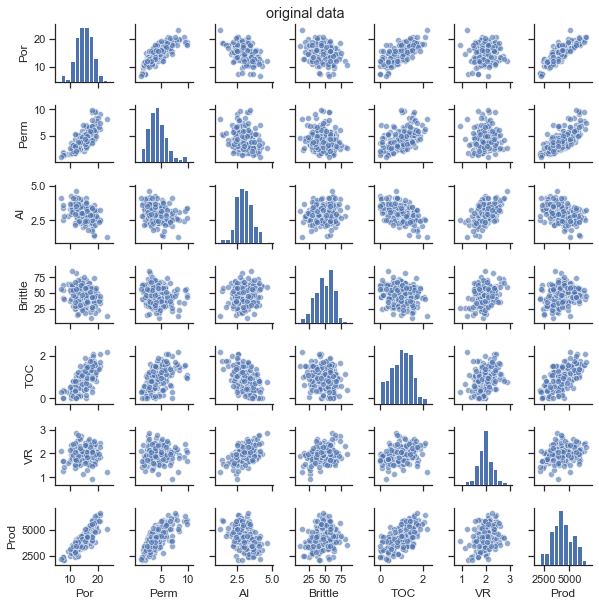

In [6]:
# visualizing reconstructed data in the original data space
import seaborn as sns
## plot reconstructed data
fh = 1.2 # figure height
sns.set(style='ticks')
h = sns.pairplot(df_recon, plot_kws={'alpha':0.6},height=fh,aspect=1)
ts1 = 'reconstruction with ' + str(p) + ' principal component(s)'
h.fig.suptitle(ts1, y=1)
# h.savefig('dfrecon')

## plot original data
sns.set(style='ticks')
i = sns.pairplot(df, plot_kws={'alpha':0.6},height=fh,aspect=1)
ts2 = 'original data'
i.fig.suptitle(ts2, y=1)
# i.savefig('dforiginal')

#### Section 2. compare random forest model with 2 predictors to 6 predictors
Here, I first build a model with two predictors as the input, because it is easier to visualize with two predictors. Then, the ensemble method can be generalized to multiple predictor features, and I can easily compare the fit with 2 and all 6 predictors.
#### random forest model with only 2 features, porosity and brittleness 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor          # random forest method
import warnings
warnings.filterwarnings("ignore") # surpress warning statement


predictor_col=['Por','Brittle'] # column names for predictors, one can check if Por Perm fits better or worse
# make a new DataFrame with predictor features for training
predictors = copy.deepcopy(df[predictor_col])
response = copy.deepcopy(df[['Prod']])

# parameters for train test split
split_params = lambda: None
split_params.test_size=0.2
split_params.rand_seed=78787

# hyperparameters for random forest
model_params = lambda: None
model_params.max_depth=9
model_params.min_samples_leaf=5
model_params.num_tree=100

# fit result using porosity and brittleness
print('predictors used: '+str(predictor_col))
fit_result=build_random_forest(predictors.values,response.values,split_params,model_params)

predictors used: ['Por', 'Brittle']
2 predictors: the R^2 of the out-of-bag score is 0.9329097955627358
2 predictors: the R^2 of the testing data is 0.9274082934128286


2 predictors model give R2 of 0.9274 on the testing data

Below is the model visualization:

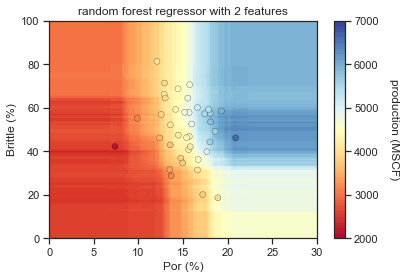

In [8]:
fig_input = lambda: None #initialize an empty object
# pass the figure parameters as an object, this help avoid passing too many parameters to a function
fig_input.npx = 1000;  fig_input.npy = 1000; fig_input.npz=20 # number of grid in x and y direction
fig_input.xmin = 0;    fig_input.ymin = 0 
fig_input.xmax = 30;   fig_input.ymax = 100
fig_input.zmin = 2000; fig_input.zmax = 7000
fig_input.cmap = plt.cm.RdYlBu
fig_input.xlabel = predictor_col[0]+' (%)'
fig_input.ylabel = predictor_col[1]+' (%)'
fig_input.title = 'random forest regressor with 2 features'
fig_input.cbartitle = 'production (MSCF)'

# getting testing data
X_test = predictors.iloc[fit_result.i_test,:].values
y_test = response.iloc[fit_result.i_test,:].values

data_test = np.c_[X_test,y_test]
visualize_model(fit_result.regressor,data_test,fig_input);

Now, the same routine is applied to the entire data sample (all 6 predictors) and obtain the R2 value of the fit to testing data

In [9]:
# first get the predictor data, big_ means more than 2 features are used
predictors_col = ['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR'] # using all features as predictors
big_predictors = df[predictors_col] # using all predictors
response = df['Prod']
print(predictors_col)
all_features_result=build_random_forest(big_predictors.values,response.values,split_params,model_params)


['Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']
6 predictors: the R^2 of the out-of-bag score is 0.9096816179367976
6 predictors: the R^2 of the testing data is 0.8912853206320825


For the random forest regressor, with 2 predictors (porosity and brittleness), the R2 value over the testing data is 0.9274. With all 6 predictors, the R2 value over the testing data is 0.8952. This means that it is possible to get worst prediction if more features are included. It potentially implies that dimensionality reduction can be applied to improve the accuracy of the model. Here, the proposed method is to use principal component analysis because it ranks the principal component with the variance explained over the dataset.

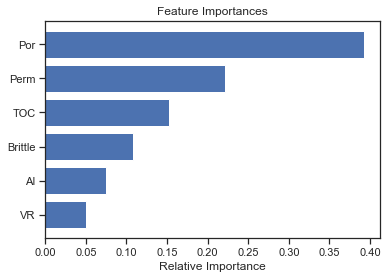

In [10]:
# plot feature importance
# code from https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
features = df.columns
importances = all_features_result.regressor.feature_importances_
indices = np.argsort(importances)  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The feature importance chart shows porosity and permeability are the two most important features. Let me verify by using porosity and permeability as predictors, see if the model can be fitted well.

In [11]:
# let us verify the fitness by using porosity and permeability
test_predictors_col = ['Por', 'Perm'] # using porosity and permeability
test_predictors = df[test_predictors_col] # using all predictors
response = df['Prod']
print(test_predictors_col)
test_result=build_random_forest(test_predictors.values,response.values,split_params,model_params)

['Por', 'Perm']
2 predictors: the R^2 of the out-of-bag score is 0.7209918814890457
2 predictors: the R^2 of the testing data is 0.6309343728031339


I plot the feature importance from the random forest regressor. The regressor shows that porosity and permeability are the two most important features, however, the model with porosity and permeability (R2=0.6309) fit much worse compared to porosity and brittle (R2=0.9274). Overall, the feature importance from random forest regressor is not reliable in this case.

#### Section 3. combine principal components with random forest
In section 1, the entire data sample is transformed into principal component score. Here, I can simpled extract the principal component scores from part I. The result is in a dictionary form:
```python
    return {'df_rc': df_rc, # data with reduced dimensionality back transformed to the original space 
            'df_pcs': df_pc_score, # principal component socre
            'pca_result': pca , # the pca instance used (this contains the explained variance)
            'scaler': scaler}   # the standard scaler used 
```
In the principal component (PC) space, the principal components no long longer have physical meaning. Hence, I cannot identify which PC corresponds to the reponse feature. However, I would expect there is a relationship/correlation between the important PC(s) (predictors) to the actual production (response). 

Here, I setup the predictors and response, and run a prototype random forest, without tuning hyperparameters.

In [12]:
df_PCS = result['df_pcs']  # data in principal component space  
pca_model = result['pca_result']
scaler = result['scaler'] # standard scaler
df_st = scaler.transform(df) # standardize the data. 
response_st = df_st[:,6] # get the column of the production data
# get index for the training and testing data
i_test = fit_result.i_test 
i_train = fit_result.i_train

#let us get predictors, which take first np column of the principal component score
npts = 2  # get np number of principal components
predictors = df_PCS.iloc[:,:npts].values

# split the data into trains and test
pc_train = predictors[i_train,:] # using index to extract train and test data
pc_test = predictors[i_test,:]

stprod_train = response_st[i_train]
stprod_test = response_st[i_test]

# declear the model and set hyperparamters
my_pc_forest = RandomForestRegressor(max_depth=6, random_state=78787,
                                        n_estimators=90, max_features='sqrt', oob_score=True) # max feature is sqrt
pc_RFRegr = my_pc_forest.fit(pc_train, stprod_train)

y_model = pc_RFRegr.predict(pc_test)

R2_oob = pc_RFRegr.oob_score_.astype(float)
fit_str_oob = 'using '+str(npts)+' principal components: the R^2 of the out-of-bag score is '+str(R2_oob)
print(fit_str_oob)

y_test = stprod_test
R2_test = pc_RFRegr.score(pc_test,y_test)
fit_str_test = 'using '+str(npts)+' principal components: the R^2 of the testing data is '+str(R2_test)
print(fit_str_test)

using 2 principal components: the R^2 of the out-of-bag score is 0.8735188607412513
using 2 principal components: the R^2 of the testing data is 0.8800152959359021


Here, the prototype model give a relatively low R2 value: 0.880, but I can improve the model by turning the hyperparameters. 

To properly contruct the model, the hyperparameters needs to be tuned. Here, I will tune maximum tree depth and number of trees. 

#### tune maximum tree depth and number of trees

In [13]:
from sklearn.model_selection import cross_val_score         # K-fold crossvalidation
predictors_tune = df_PCS.iloc[:,:6].values # X is the predictors, using all principal component 
response_tune = response_st # y is the response, standardized production

min_dpth = 2; max_dpth =20
max_depth_tune = np.arange(min_dpth,max_dpth,1) # array contains max tree depth
min_ntree = 10; max_ntree=150 
num_tree_tune = np.arange(min_ntree,max_ntree,20) # array contains possible values of number of trees
score_tune = np.zeros((len(max_depth_tune),len(num_tree_tune))) # initialize matrix of 0s to store validation scores
rand_seed=78787

for i in np.arange(len(max_depth_tune)):
    print('patient, running and testing max depth: ' +str(max_depth_tune[i])) # print to ensure code is runing
    for j in np.arange(len(num_tree_tune)):
        max_depth = max_depth_tune[i] 
        num_tree = num_tree_tune[j]
        # declear the random forest model
        pc_forest = RandomForestRegressor(max_depth=max_depth, random_state=rand_seed,
                                        n_estimators=num_tree, max_features='sqrt', oob_score=True) # max feature is sqrt

        scores = cross_val_score(estimator=pc_forest, X= predictors_tune, y=response_tune,
                                 cv=5, n_jobs=8, scoring = 'r2') # using R2 as the goodness of the model

        score_tune[i,j]=np.mean(scores)       

patient, running and testing max depth: 2
patient, running and testing max depth: 3
patient, running and testing max depth: 4
patient, running and testing max depth: 5
patient, running and testing max depth: 6
patient, running and testing max depth: 7
patient, running and testing max depth: 8
patient, running and testing max depth: 9
patient, running and testing max depth: 10
patient, running and testing max depth: 11
patient, running and testing max depth: 12
patient, running and testing max depth: 13
patient, running and testing max depth: 14
patient, running and testing max depth: 15
patient, running and testing max depth: 16
patient, running and testing max depth: 17
patient, running and testing max depth: 18
patient, running and testing max depth: 19


Next, let us visualize the $R^2$ values as a function of max tree depth and number of tree (when averaging the trees).

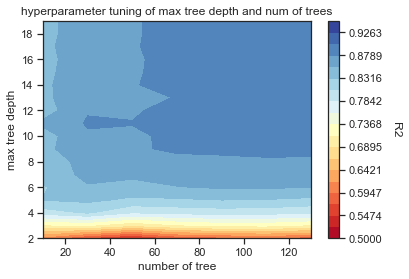

In [14]:
#generate mesh grid
xmesh, ymesh = np.meshgrid(num_tree_tune,max_depth_tune)
z_min = 0.5; z_max =0.95 
lv=np.linspace(z_min, z_max, 20)

# plot contour map for the R2 as function of max tree depth and number of trees
r2csf = plt.contourf(xmesh, ymesh, score_tune, cmap=plt.cm.RdYlBu, vmin=z_min, vmax=z_max, levels=lv)
plt.title('hyperparameter tuning of max tree depth and num of trees')
plt.xlabel('number of tree')
plt.ylabel('max tree depth')

plt.xlim(np.min(num_tree_tune),np.max(num_tree_tune))
plt.ylim(np.min(max_depth_tune),np.max(max_depth_tune))
cbar = plt.colorbar(r2csf, orientation = 'vertical')
cbar.set_label('R2 ', rotation=270, labelpad=20)


From the plot of the cross validation scores, I can observed the following: 1) increase max tree depth generally improves the R2 value of the model, but the benefits diminish when the tree depth is greater than 9, 2) at high max tree depth (>8), increasing number of tree does not necessary results in a better model, (R2 values can decrease with number of trees). 

To prevent overfit, the max tree depth and number of tree should be as low as possible while keep a decent R2 value of the model prediction. A combination of the hyperparamters that is close the origin, and still gives R2 above 0.83 is max tree depth of 9 and number of tree of 100. 

With these hyperparameters, let us test how many principal components should I use to build a model for production. 

#### tune number of principal components

In [15]:
# again load the data which is the principle component scores, this is the same data we used before
predictors_tune = df_PCS.iloc[:,:6].values # X is the predictors, using all principal component 
response_tune = response_st                # y is the response, standardized production

# now declear the hyperparameter, which the number of principal component
feature_total = 6 # there are total 6 featuer so 6 total PCs
n_pc_tune = np.arange(feature_total) # there are total 6 features, so the arrange should have 6 elements 0 through 5

# specify the hyperprameter that are tuned already
max_tree_depth = 9
num_tree = 100
score_npc= np.zeros(feature_total)

# set a loop for cross validation
for i in np.arange(feature_total):
    n_pc=n_pc_tune[i]
    npc_forest = RandomForestRegressor(max_depth=max_tree_depth, random_state=rand_seed,
                                      n_estimators=num_tree, max_features='sqrt', oob_score=True) # max feature is sqrt
    
    x_tune = predictors_tune[:,:n_pc+1] #change number of principal components also changes the input data
    scores = cross_val_score(estimator=npc_forest, X= x_tune, y=response_tune,
                             cv=5, n_jobs=8, scoring = 'r2') # using R2 as the goodness of the model
    
    score_npc[i]=np.mean(scores)

# let us plot the score for each of the principal component used

Let us plot the score for each of the principal component used.

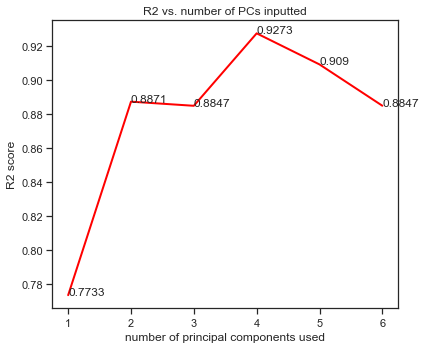

In [16]:
plt.subplot(111)
plt.plot(np.arange(feature_total)+1, score_npc, color = 'red', linewidth = 2)
# annotate the points
for i in np.arange(feature_total):
    txt = str(np.round(score_npc[i],4))
    plt.annotate(txt, (i+1, score_npc[i]))
    
plt.title('R2 vs. number of PCs inputted'); 
plt.xlabel('number of principal components used'); plt.ylabel('R2 score')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=1.0, wspace=0.3, hspace=0.2)

The plot shows that using 4 PCs results the best fit in the testing data. Additionally, using 2 PCs is better than 1 PC, and interestingly, 3 PCs is worse than 2 PCs, similarly, 5 and 6 PC is worse than 4 PCs. Another interesting observation is that the R2 score of 6 PCs is equivalent to 2 PCs. The goodness of the model highly fluncuate with the number PC inputted, in other words, there are multiple local maximum of the R2 value.

### Discussion of number of PCs
The number of PCs affects the number of randomly selected feature for tree split. If $n$ is the number of principle components inputted, then the number of the random feature is $floor(\sqrt{n})$. For instance, when 4 PCs are used, 2 features can be randomly selected, and it remains the same for 5 and 6 PCs. The additional PCs does not impact the number of randomly selected features, and it just causes overfit of the sample, thus reduces the R2 value.

#### Double check the hyperparameters after number of PCs are tuned
Once 4 principal components are selected, it is good to reiterate the tuning process to ensure that previously tuned tree depth and number of tree are still good.

patient, running and testing max depth: 4
patient, running and testing max depth: 5
patient, running and testing max depth: 6
patient, running and testing max depth: 7
patient, running and testing max depth: 8
patient, running and testing max depth: 9
patient, running and testing max depth: 10
patient, running and testing max depth: 11
patient, running and testing max depth: 12
patient, running and testing max depth: 13
patient, running and testing max depth: 14
patient, running and testing max depth: 15


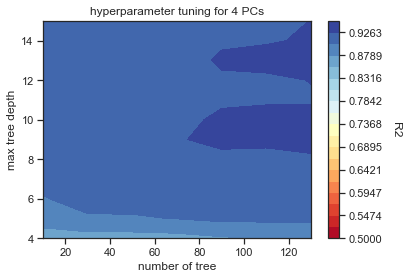

In [17]:
# here re-tune the max tree depth and number of trees
predictors_tune = df_PCS.iloc[:,:4].values # X is the predictors, using 4 principle from the tuning result 
response_tune = response_st # y is the response, standardized production

min_dpth = 4; max_dpth =16
max_depth_tune = np.arange(min_dpth,max_dpth,1)
min_ntree = 10; max_ntree=150
num_tree_tune = np.arange(min_ntree,max_ntree,20)
score_tune = np.zeros((len(max_depth_tune),len(num_tree_tune)))

for i in np.arange(len(max_depth_tune)):
    print('patient, running and testing max depth: ' +str(max_depth_tune[i]))
    for j in np.arange(len(num_tree_tune)):
        max_depth = max_depth_tune[i] 
        num_tree = num_tree_tune[j]
        # declear the random forest model
        pc_forest = RandomForestRegressor(max_depth=max_depth, random_state=rand_seed,
                                        n_estimators=num_tree, max_features='sqrt', oob_score=True) # max feature is sqrt

        scores = cross_val_score(estimator=pc_forest, X= predictors_tune, y=response_tune,
                                 cv=5, n_jobs=8, scoring = 'r2') # using R2 as the goodness of the model

        score_tune[i,j]=np.mean(scores)       

        
# visualize the hyperparameter space
xmesh, ymesh = np.meshgrid(num_tree_tune,max_depth_tune)
z_min = 0.5; z_max =0.95 
lv=np.linspace(z_min, z_max, 20)

r2csf = plt.contourf(xmesh, ymesh, score_tune, cmap=plt.cm.RdYlBu, vmin=z_min, vmax=z_max, levels=lv)
plt.title('hyperparameter tuning for 4 PCs')
plt.xlabel('number of tree')
plt.ylabel('max tree depth')

plt.xlim(np.min(num_tree_tune),np.max(num_tree_tune))
plt.ylim(np.min(max_depth_tune),np.max(max_depth_tune))
cbar = plt.colorbar(r2csf, orientation = 'vertical')
cbar.set_label('R2 ', rotation=270, labelpad=20)

Previouly, I tuned the tree depth and number of tree using all 6 principle components. Here, I re-tuned these hyperparameter with only 4 PCs. The plot shows that the hyperpameters (max_depth=9, and num_tree=100) are still good. Now, I can finalized the model with all hyperparameters: tree depth = 9, number of tree = 100, and number of PCs = 4.

#### Section 4. finalize the model and compare model estimate to data

the R2 value of the training data is 0.9879546763064695
the R2 value of the testing data is 0.9360588110424918


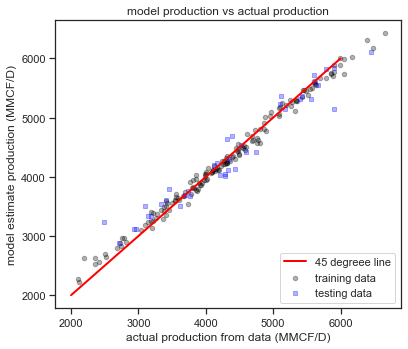

In [18]:
# I reload the data every time before I initialize the model
number_pc=4 # the tuned value is 4 but can be change to 1 2 3 4 5 6
predictors_f = df_PCS.iloc[:,:number_pc].values # X is the predictors, using 4 principle from the tuning result 
prod_data = df['Prod'].values # work with numpy array rather than tuple

data_scaler = StandardScaler().fit(prod_data.reshape(-1,1)) # apply standard scaler to the production data, need reshape for single feature
response_f = data_scaler.transform(prod_data.reshape(-1,1)) # transform the production data

# split training and testing data
X_train, X_test, i_train, i_test = train_test_split(predictors_f, np.arange(len(predictors_f)),
                                                    test_size=0.2, random_state=None)
# i will use the indexes to get the training and testing data

# use tuned hyperparameter
num_tree = 100
max_depth = 9
# initialize the model
my_forest_model = RandomForestRegressor(max_depth=max_depth, random_state=None,
                                        n_estimators=num_tree, max_features='sqrt', oob_score=True) # max feature is sqrt
# fit the model with training data
myRFR_model = my_forest_model.fit(predictors_f[i_train,:], response_f[i_train])

# use model to estiamte training and testing data
# estimate training data
train_model_estimate = myRFR_model.predict(predictors_f[i_train,:])
train_prod_estimate = data_scaler.inverse_transform(train_model_estimate)
response_train = prod_data[i_train]

# estimate testing data
test_model_estimate = myRFR_model.predict(predictors_f[i_test,:]) # get model predictions
test_prod_estimate = data_scaler.inverse_transform(test_model_estimate) # re-scale the data to original units

response_test = prod_data[i_test]

# I want to compare the model_estiamte and response_test in a plot
plt.subplot(111)
plt.scatter(response_train, train_prod_estimate,color = 'black',marker='o',s = 20, alpha = 0.3,label = 'training data')
plt.scatter(response_test, test_prod_estimate ,color = 'blue',marker='s',s = 20, alpha = 0.3,label = 'testing data')
plt.plot([2000, 6000],[2000, 6000], color = 'red', linewidth =2, label = '45 degreee line')
plt.legend(loc='lower right')
plt.title('model production vs actual production')
plt.xlabel('actual production from data (MMCF/D)'); plt.ylabel('model estimate production (MMCF/D)')
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=1.0, wspace=0.3, hspace=0.2)


# calculate R2 score
from sklearn.metrics import r2_score
train_score = r2_score(response_train,train_prod_estimate)
test_score = r2_score(response_test,test_prod_estimate)
train_str = 'the R2 value of the training data is '+str(train_score)
test_str = 'the R2 value of the testing data is '+str(test_score)

print(train_str)
print(test_str)

Without explicit feature selections, I use 4 principal components to model the production data. The model performs better compared to the cases without dimensionality reduction (all 6 original features). The R2 score is close to the model result that uses porosity and brittleness. There are still some bias in our model, the model tends to underestimate the production at high production rates (>5000 MMCF/D), and overestimate the production at low production rates (<3500 MMCF/D). A slight increase in the model complexity may be helpful in reducing the bias, but the room for improvement is limited because of the bias-variance trade-off.

Finally, this workflow is a demonstration of combining principal component analysis and random forest. Both techniques helps address the issue of overfitting. The main limitation of this method is that principle component analysis relies on linear assumptions. In other words, orthogonal projections are not always meaningful, especially when the data is not linear. In this case, feature engineering becomes important. 